<div align="center">

#  University of Thessaly  
## Speech Processing CE457-UTH – Final Project  


**Theodora Poultsidou** *(03176)*  

## Project Title : *Music Genre Classification* 

</div>

## Import Libraries


In [35]:
import os  
import numpy as np  
import scipy.stats  # For the statistical functions and probability distributions
import scipy  
import joblib  # For saving and loading the models
import librosa  # For audio processing and feature extraction
from scipy.io import savemat, loadmat, wavfile  # For reading/writing  WAV files
from sklearn.cluster import KMeans  
from sklearn.mixture import GaussianMixture  # For Gaussian Mixture Model (GMM) clustering
from scipy.spatial.distance import cdist  # For computing distances between data points
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score
from collections import defaultdict




## Feature Extraction Using MFCCs
---



In [19]:
# Function to extract MFCC features from an audio file
def extract_mfcc(audio_path, frame_size=0.02, step_size=0.005, n_mfcc=13, sr=22050):

    # Load the audio with sample rate sr
    signal, sample_rate = librosa.load(audio_path, sr=sr)

    # Calculaate the frame length and hop length
    frame_length = int(frame_size * sample_rate)
    hop_length = int(step_size * sample_rate)

    # Extract the MFCC features 
    features = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=n_mfcc, n_fft=frame_length, hop_length=hop_length).T            

    return features


#### Process Each Dataset, Train and Test
For each training and testing dataset, for every audio (.wav) file in each category, we extract the MFCC features and save them in the features file(.mat) to use later for the training and the evaluation.

In [20]:
# Paths for training and testing datasets
datasets = {
    "Training": {
        "music": "/Users/theodorapoultsidou/Desktop/Speech_Processing/Assigments/Project/Music-Genres/Training",
        "features": "/Users/theodorapoultsidou/Desktop/Speech_Processing/Assigments/Project/Music-Genres/MFCC-Features/Training"
    },
    "Testing": {
        "music": "/Users/theodorapoultsidou/Desktop/Speech_Processing/Assigments/Project/Music-Genres/Testing",
        "features": "/Users/theodorapoultsidou/Desktop/Speech_Processing/Assigments/Project/Music-Genres/MFCC-Features/Testing"
    }
}

# Process each dataset, train and test
for dataset_name, paths in datasets.items():
    music_files = paths["music"]
    mfcc_features_path = paths["features"]
    os.makedirs(mfcc_features_path, exist_ok=True)
    
    # Walk through the music files
    for root, dirs, files in os.walk(music_files):
        for file_name in files:
            if file_name.endswith('.wav'):
                audio_file_path = os.path.join(root, file_name)
                genre = os.path.basename(root)
                genre_mfcc_features = os.path.join(mfcc_features_path, genre)
                os.makedirs(genre_mfcc_features, exist_ok=True)
                
                # Extract and save MFCC features
                mfccs = extract_mfcc(audio_file_path)
                save_path = os.path.join(genre_mfcc_features, f"{os.path.splitext(file_name)[0]}.mat")
                savemat(save_path, {'MFCCs': mfccs})

## Training GMMs
---

In [21]:
# Function to update the posterior probabilities for the Estimation-step
def update_posterior(data_points, priors, means, covariances):

    number_of_data_points, number_of_features = data_points.shape
    number_of_gaussians = len(priors)
    
    # Compute the posterior for each data point and each Gaussian
    posterior = np.zeros((number_of_data_points, number_of_gaussians))

    for g in range(number_of_gaussians):
        # Evaluate the Gaussian pdf for each data point
        gaussian_pdf_values = multivariate_normal.pdf(
            data_points, mean=means[g], cov=covariances[g], allow_singular=True
        )
        # Multiply by the prior 
        posterior[:, g] = priors[g] * gaussian_pdf_values
    
    # Normalize so that each data point's posterior sums to 1
    sum_posterior = np.sum(posterior, axis=1, keepdims=True)
    sum_posterior[sum_posterior == 0] = 1  # Avoid the division by zero
    posterior /= sum_posterior
    
    return posterior



In [22]:
# Function to update the priors for the Maximization-step
def update_priors(posterior):
    
    number_of_data_points, number_of_gaussians = posterior.shape

    # calculate the number of data points assigned to each Gaussian (sum of the posterior)
    sum_posterior = np.sum(posterior, axis=0)

    priors = (sum_posterior + 1e-6) / posterior.shape[1]  # Add a small value to avoid division by zero

    return priors

In [23]:
# Function to update the means for the Maximization-step
def update_means(data_points, posterior):
    
    number_of_data_points, number_of_features = data_points.shape
    number_of_gaussians = posterior.shape[1]
    
    # initialize the means 
    means = np.zeros((number_of_gaussians, number_of_features))

    # calculate the number of data points assigned to each Gaussian (sum of the posterior)
    sum_posteriors = np.sum(posterior, axis=0)
    
    for g in range(number_of_gaussians):
        
        # Sum of the data points multiplied by their posterior probability
        weighted_sum = np.sum(data_points * posterior[:, g][:, np.newaxis], axis=0)
        means[g] = weighted_sum / (sum_posteriors[g] + 1e-10)
    
    return means

In [24]:
# Function to update the covariance matrices for the Maximization-step
def update_covariances(data_points, posterior, means, covariance_type='full'):
   
    number_of_data_points, number_of_features = data_points.shape
    number_of_gaussians = posterior.shape[1]
    
    covariances = []
    sum_posteriors = np.sum(posterior, axis=0)
    
    for g in range(number_of_gaussians):
        # Compute the difference between each data point and the mean
        diff = data_points - means[g]  

        # Multiply each difference by the posterior probability for that Gaussian
        weighted_diff = diff * posterior[:, g][:, np.newaxis] 
        
        # Compute the covariance matrix
        covariance_matrix = np.dot(weighted_diff.T, diff) / (sum_posteriors[g] + 1e-3)
        
        # If covariance_type is 'diag', then set the off-diagonal elements to zero
        if covariance_type == 'diag':
            covariance_matrix = np.diag(np.diag(covariance_matrix))
        
        covariances.append(covariance_matrix)
    
    return np.array(covariances)



In [25]:
# Function to compute the log-likelihood 
def compute_log_likelihood(data_points, priors, means, covariances):
    
    # Compute the likelihood for each data point and each Gaussian
    likelihood = np.zeros((data_points.shape[0], len(priors)))
    for g in range(len(priors)):
        likelihood[:, g] = priors[g] * multivariate_normal.pdf(
            data_points, mean=means[g], cov=covariances[g], allow_singular=True
        )
    return np.sum(np.log(np.sum(likelihood, axis=1) + 1e-6))  # Avoid log(0)


In [26]:
# Function to train a Gaussian Mixture Model using the Expectation-Maximization algorithm
def gmm_em(data_points, number_of_gaussians, max_iterations=100, tolerance=1e-8, covariance_type='full'):
    
    # Initialize means with KMeans 
    kmeans = KMeans(n_clusters=number_of_gaussians, n_init=50, random_state=42) 
    cluster_labels = kmeans.fit_predict(data_points)
    means = kmeans.cluster_centers_
    
    # Initialize priors
    priors = np.zeros(number_of_gaussians)
    for i in range(number_of_gaussians):
        priors[i] = np.mean(cluster_labels == i)
    
    # Initialize covariances 
    number_of_data_points, number_of_features = data_points.shape
    covariances = []

    for i in range(number_of_gaussians):
        cluster_data = data_points[cluster_labels == i]
        covariance_matrix = np.cov(cluster_data.T) + 1e-6 * np.eye(number_of_features)
        covariances.append(covariance_matrix)
    covariances = np.array(covariances)
    
    
    # Keep all the log-likelihoods to check for convergence
    loglikehood_list = []
    
    for iteration in range(max_iterations):
        # Estimation-step 
        posterior = update_posterior(data_points, priors, means, covariances)
        
        # Maximization-step 
        priors = update_priors(posterior)
        means = update_means(data_points, posterior)
        covariances = update_covariances(data_points, posterior, means, covariance_type)
        
        # Compute log-likelihood 
        current_loglikehood = compute_log_likelihood(data_points, priors, means, covariances)
        loglikehood_list.append(current_loglikehood)
        
        # Check for convergence
        if iteration > 0 and abs(loglikehood_list[-1] - loglikehood_list[-2]) < tolerance:
            break
        
    return priors, means, covariances, loglikehood_list


In [ ]:
# train and save GMM for each class usint the training data
def train_and_save_gmm_for_class(class_name, class_folder,
                                 number_of_gaussians, max_iterations,
                                 tolerance, covariance_type, save_path,
                                 normalize=True):
   
    print(f"Training custom GMM for class: {class_name}")

    # Ensure the class folder exists
    if not os.path.exists(class_folder):
        print(f"Error: Folder {class_folder} does not exist.")
        return None

    if not os.path.exists(save_path):
        os.makedirs(save_path)  # Create the save directory if it doesn't exist
    
    # Load all MFCC features for this class
    mfcc_features_list = []
    for file_name in os.listdir(class_folder):
        if file_name.endswith(".mat"):
            mat_file_path = os.path.join(class_folder, file_name)
            try:
                mat_data = loadmat(mat_file_path)
                mfcc_key = 'MFCCs' if 'MFCCs' in mat_data else None
                if mfcc_key is None:
                    continue
                mfccs = mat_data[mfcc_key]
                if mfccs.size == 0:
                    continue
                mfcc_features_list.append(mfccs)
            except Exception as e:
                print(f"Error loading {file_name}: {e}.")
    
    if not mfcc_features_list:
        print(f"Error: No valid MFCC data found for {class_name}.")
        return None

    mfcc_features = np.vstack(mfcc_features_list)
    
    # Train the GMM using the EM algorithm
    priors, means, covariances, loglikehood_history = gmm_em(
            mfcc_features,
            number_of_gaussians=number_of_gaussians,
            max_iterations=max_iterations,
            tolerance=tolerance,
            covariance_type=covariance_type
    )
   
    # Save the GMM model parameters
    gmm_model = {
        "priors": priors,
        "means": means,
        "covariances": covariances,
        "loglikehood_history": loglikehood_history
    }
    model_filename = f"{class_name}_GMM.pkl"
    model_path = os.path.join(save_path, model_filename)
    joblib.dump(gmm_model, model_path)
    print(f"Saved GMM for {class_name} at {model_path}")

    return gmm_model


In [ ]:
# Paths for MFCC features (training set) and where to save the GMM models
mfcc_root = "/Users/theodorapoultsidou/Desktop/Speech_Processing/Assigments/Project/Music-Genres/MFCC-Features/Training/"
gmm_save_path = "/Users/theodorapoultsidou/Desktop/Speech_Processing/Assigments/Project/Music-Genres/GMM-Models"
os.makedirs(gmm_save_path, exist_ok=True)

# Hyperparameters for GMM training
max_iterations = 150
number_of_gaussians = 5
covariance_type = 'full'
tolerance = 1e-8

# Train a GMM for each class (genre)
gmm_models = {}
for class_name in os.listdir(mfcc_root):
    class_folder = os.path.join(mfcc_root, class_name)
    if os.path.isdir(class_folder):
        model = train_and_save_gmm_for_class(
            class_name,
            class_folder,
            number_of_gaussians,
            max_iterations,
            tolerance,
            covariance_type,
            gmm_save_path
        )
        if model is not None:
            gmm_models[class_name] = model

Training custom GMM for class: blues
Saved GMM for blues at /Users/theodorapoultsidou/Desktop/Speech_Processing/Assigments/Project/Music-Genres/GMM-Models/blues_GMM.pkl
Training custom GMM for class: reggae
Saved GMM for reggae at /Users/theodorapoultsidou/Desktop/Speech_Processing/Assigments/Project/Music-Genres/GMM-Models/reggae_GMM.pkl
Training custom GMM for class: classical
Saved GMM for classical at /Users/theodorapoultsidou/Desktop/Speech_Processing/Assigments/Project/Music-Genres/GMM-Models/classical_GMM.pkl


## Classification and Evaluation
---

In [29]:
# Function to classify a signal using the trained GMM models and  MAP criterion
def classify_signal(mfcc_features, gmm_models):
    
    likelihoods = {}
    for class_name, model in gmm_models.items():
        priors = model["priors"]
        means = model["means"]
        covariances = model["covariances"]
        # Compute the log-likelihood for this signal under the class GMM
        loglikehood = compute_log_likelihood(mfcc_features, priors, means, covariances)
        likelihoods[class_name] = loglikehood
        
    # MAP: choose the class with the highest log-likelihood
    predicted_class = max(likelihoods, key=likelihoods.get)
    return predicted_class, likelihoods



In [ ]:
# Function that evaluates the classification performance 
def evaluate_classification(test_data_root, gmm_models):
    """Evaluate classification performance with accuracy, precision, recall, F1-score, and class-wise predictions."""
    
    total_samples = 0
    correct_predictions = 0
    true_labels = []
    predicted_labels = []
    
    # Dictionary to store the actual vs. predicted class counts
    class_predictions = defaultdict(lambda: defaultdict(int))
    class_counts = defaultdict(int)  # Total count of instances per true class

    for true_class in os.listdir(test_data_root):
        class_folder = os.path.join(test_data_root, true_class)
        if os.path.isdir(class_folder):
            for file_name in os.listdir(class_folder):
                if file_name.endswith(".mat"):
                    mat_file_path = os.path.join(class_folder, file_name)
                    mat_data = loadmat(mat_file_path)
                    
                    # Get MFCC data
                    mfcc_key = 'MFCCs' if 'MFCCs' in mat_data else list(mat_data.keys())[-1]
                    test_mfcc = mat_data[mfcc_key]
                    
                    # Predict class using the trained GMM models
                    predicted_class, _ = classify_signal(test_mfcc, gmm_models)
                    
                    total_samples += 1
                    true_labels.append(true_class)
                    predicted_labels.append(predicted_class)
                    
                    # Count correct predictions
                    if predicted_class == true_class:
                        correct_predictions += 1
                    
                    
                    class_counts[true_class] += 1
                    class_predictions[true_class][predicted_class] += 1

    # Compute classification metrics
    accuracy = correct_predictions / total_samples if total_samples > 0 else 0
    precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=1)
    recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=1)
    f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=1)

    # Print results
    print(f"Classification Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1 Score: {f1 * 100:.2f}%\n")

    print("For each class predictions breakdown:")
    for true_class, predictions in class_predictions.items():
        print(f"\nActual Class: {true_class} ({class_counts[true_class]} samples)")
        for predicted_class, count in predictions.items():
            print(f"  Predicted as {predicted_class}: {count}")

    # Return metrics and all breakdown
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "class_predictions": class_predictions,
        "class_counts": class_counts
    }


In [36]:
# Define path for test MFCC features
test_mfcc_root = "/Users/theodorapoultsidou/Desktop/Speech_Processing/Assigments/Project/Music-Genres/MFCC-Features/Testing/"

# Evaluate the classifier
evaluate_classification(test_mfcc_root, gmm_models)

Classification Accuracy: 82.26%
Precision: 83.58%
Recall: 82.26%
F1 Score: 82.05%

For each class predictions breakdown:

Actual Class: blues (21 samples)
  Predicted as blues: 17
  Predicted as classical: 3
  Predicted as reggae: 1

Actual Class: reggae (20 samples)
  Predicted as reggae: 14
  Predicted as blues: 3
  Predicted as classical: 3

Actual Class: classical (21 samples)
  Predicted as classical: 20
  Predicted as blues: 1


{'accuracy': 0.8225806451612904,
 'precision': 0.835814722911497,
 'recall': 0.8225806451612904,
 'f1_score': 0.8205216197666438,
 'class_predictions': defaultdict(<function __main__.evaluate_classification.<locals>.<lambda>()>,
             {'blues': defaultdict(int,
                          {'blues': 17, 'classical': 3, 'reggae': 1}),
              'reggae': defaultdict(int,
                          {'reggae': 14, 'blues': 3, 'classical': 3}),
              'classical': defaultdict(int, {'classical': 20, 'blues': 1})}),
 'class_counts': defaultdict(int,
             {'blues': 21, 'reggae': 20, 'classical': 21})}

## Analysis and Experiments 
---

In [38]:
# Paths to MFCC features (training set) and where to save the GMM models
mfcc_root = "/Users/theodorapoultsidou/Desktop/Speech_Processing/Assigments/Project/Music-Genres/MFCC-Features/Training/"
gmm_save_path = "/Users/theodorapoultsidou/Desktop/Speech_Processing/Assigments/Project/Music-Genres/GMM-Models/"
os.makedirs(gmm_save_path, exist_ok=True)

# The parameters for GMM training
max_iterations = 150
covariance_type = 'full'
tolerance = 1e-8

# Path to test MFCC features
test_mfcc_root = "/Users/theodorapoultsidou/Desktop/Speech_Processing/Assigments/Project/Music-Genres/MFCC-Features/Testing/"

# Different numbers of Gaussians to try
gaussian_numbers = [1, 2, 4, 8, 16, 32]

# Dictionary to store evaluation metrics for each number of Gaussians
evaluation_metrics = {}

for number_of_gaussians in gaussian_numbers:
    # Train a GMM for each class with the current number of Gaussians
    print(f"Training GMMs with {number_of_gaussians} Gaussians")
    gmm_models = {}
    for class_name in os.listdir(mfcc_root):
        class_folder = os.path.join(mfcc_root, class_name)
        if os.path.isdir(class_folder):
            model = train_and_save_gmm_for_class(
                class_name,
                class_folder,
                number_of_gaussians,
                max_iterations,
                tolerance,
                covariance_type,
                gmm_save_path
            )
            if model is not None:
                gmm_models[class_name] = model

    # Evaluate the classifier and store the metrics
    metrics = evaluate_classification(test_mfcc_root, gmm_models)
    evaluation_metrics[number_of_gaussians] = metrics



Training GMMs with 1 Gaussians
Training custom GMM for class: blues
Saved GMM for blues at /Users/theodorapoultsidou/Desktop/Speech_Processing/Assigments/Project/Music-Genres/GMM-Models/blues_GMM.pkl
Training custom GMM for class: reggae
Saved GMM for reggae at /Users/theodorapoultsidou/Desktop/Speech_Processing/Assigments/Project/Music-Genres/GMM-Models/reggae_GMM.pkl
Training custom GMM for class: classical
Saved GMM for classical at /Users/theodorapoultsidou/Desktop/Speech_Processing/Assigments/Project/Music-Genres/GMM-Models/classical_GMM.pkl
Classification Accuracy: 83.87%
Precision: 86.45%
Recall: 83.87%
F1 Score: 83.10%

For each class predictions breakdown:

Actual Class: blues (21 samples)
  Predicted as blues: 20
  Predicted as classical: 1

Actual Class: reggae (20 samples)
  Predicted as reggae: 12
  Predicted as blues: 4
  Predicted as classical: 4

Actual Class: classical (21 samples)
  Predicted as classical: 20
  Predicted as blues: 1
Training GMMs with 2 Gaussians
Trai

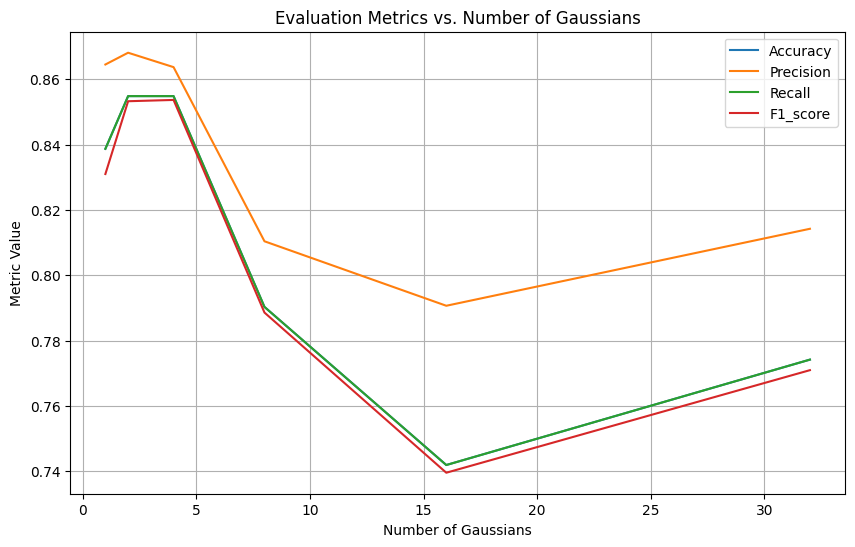

In [42]:
# Plot the evaluation metrics
plt.figure(figsize=(10, 6))
metric_names = ['accuracy', 'precision', 'recall', 'f1_score']
for metric_name in metric_names:
    metric_values = [evaluation_metrics[gaussians][metric_name] for gaussians in gaussian_numbers]
    plt.plot(gaussian_numbers, metric_values, label=metric_name.capitalize())

plt.xlabel('Number of Gaussians')
plt.ylabel('Metric Value')
plt.title('Evaluation Metrics vs. Number of Gaussians')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Expreiment with different covariance types **DIagonal**



# Paths to MFCC features (training set) and where to save the GMM models
mfcc_root = "/Users/theodorapoultsidou/Desktop/Speech_Processing/Assigments/Project/Music-Genres/MFCC-Features/Training/"
gmm_save_path = "/Users/theodorapoultsidou/Desktop/Speech_Processing/Assigments/Project/Music-Genres/GMM-Models/"
os.makedirs(gmm_save_path, exist_ok=True)

# The parameters for GMM training
max_iterations = 150
covariance_type = 'diag'
tolerance = 1e-8

# Path to test MFCC features
test_mfcc_root = "/Users/theodorapoultsidou/Desktop/Speech_Processing/Assigments/Project/Music-Genres/MFCC-Features/Testing/"

# Different numbers of Gaussians to try
gaussian_numbers = [1, 2, 4, 8, 16, 32]

# Dictionary to store evaluation metrics for each number of Gaussians
evaluation_metrics = {}

for number_of_gaussians in gaussian_numbers:
    # Train a GMM for each class with the current number of Gaussians
    gmm_models = {}
    for class_name in os.listdir(mfcc_root):
        class_folder = os.path.join(mfcc_root, class_name)
        if os.path.isdir(class_folder):
            model = train_and_save_gmm_for_class(
                class_name,
                class_folder,
                number_of_gaussians,
                max_iterations,
                tolerance,
                covariance_type,
                gmm_save_path
            )
            if model is not None:
                gmm_models[class_name] = model

    # Evaluate the classifier and store the metrics
    metrics = evaluate_classification(test_mfcc_root, gmm_models)
    evaluation_metrics[number_of_gaussians] = metrics



Training custom GMM for class: blues
Saved GMM for blues at /Users/theodorapoultsidou/Desktop/Speech_Processing/Assigments/Project/Music-Genres/GMM-Models/blues_GMM.pkl
Training custom GMM for class: reggae
Saved GMM for reggae at /Users/theodorapoultsidou/Desktop/Speech_Processing/Assigments/Project/Music-Genres/GMM-Models/reggae_GMM.pkl
Training custom GMM for class: classical
Saved GMM for classical at /Users/theodorapoultsidou/Desktop/Speech_Processing/Assigments/Project/Music-Genres/GMM-Models/classical_GMM.pkl
Classification Accuracy: 72.58%
Precision: 73.85%
Recall: 72.58%
F1 Score: 72.85%

For each class predictions breakdown:

Actual Class: blues (21 samples)
  Predicted as blues: 16
  Predicted as classical: 3
  Predicted as reggae: 2

Actual Class: reggae (20 samples)
  Predicted as reggae: 15
  Predicted as classical: 3
  Predicted as blues: 2

Actual Class: classical (21 samples)
  Predicted as blues: 7
  Predicted as classical: 14
Training custom GMM for class: blues
Save

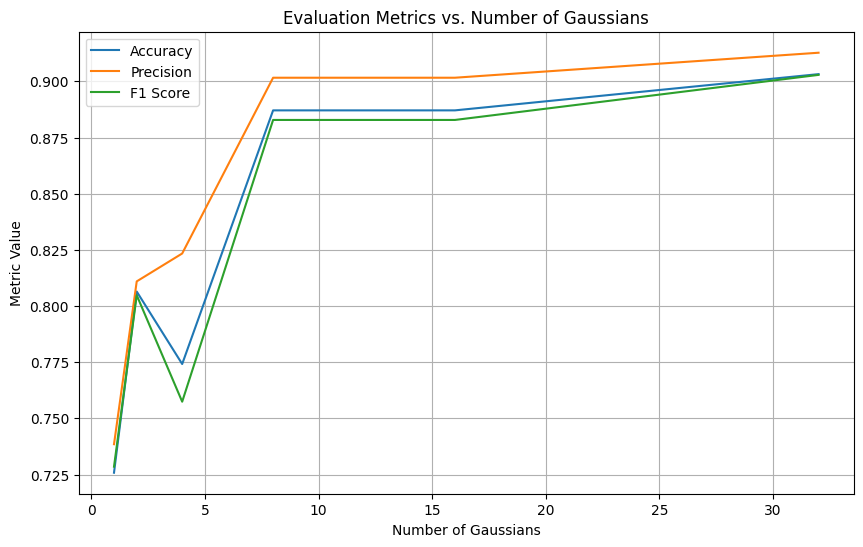

In [ ]:
# Plot the evaluation metrics
plt.figure(figsize=(10, 6))
metric_names = ['Accuracy', 'Precision', 'F1 Score']
for i, metric_name in enumerate(metric_names):
    metric_values = [evaluation_metrics[gaussians][i] for gaussians in gaussian_numbers]
    plt.plot(gaussian_numbers, metric_values, label=metric_name)

plt.xlabel('Number of Gaussians')
plt.ylabel('Metric Value')
plt.title('Evaluation Metrics vs. Number of Gaussians')
plt.legend()
plt.grid(True)
plt.show()